In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chinki86","key":"2b37558d5b359235a655730a30d3156b"}'}

In [2]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install kaggle

!kaggle datasets download -d snap/amazon-fine-food-reviews

import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

-rw-r--r-- 1 root root 64 Feb 21 18:04 kaggle.json
 99% 247M/251M [00:06<00:00, 39.3MB/s]
100% 251M/251M [00:06<00:00, 41.8MB/s]


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [0]:
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
# display = pd.read_sql_query("""
# SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
# FROM Reviews
# GROUP BY UserId
# HAVING COUNT(*)>1
# """, con)

In [0]:
# print(display.shape)
# display.head()

In [0]:
# display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
# display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND UserId="AR5J8UI46CURR"
# ORDER BY ProductID
# """, con)
# display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# # printing some random reviews
# sent_0 = final['Text'].values[0]
# print(sent_0)
# print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

In [0]:
# # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

# print(sent_0)

In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [0]:
# #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
# print(sent_0)

In [0]:
# #remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:20<00:00, 2272.05it/s]


In [0]:
# preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [12]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 46071/46071 [00:14<00:00, 3255.49it/s]


In [0]:
final["Cleaned_Text"] = preprocessed_reviews
final["Cleaned_Summary"] = preprocessed_summary

# Combining them

final["Final_Text"] = final['Cleaned_Text'].values + " " + final['Cleaned_Summary'].values 

In [14]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary,Final_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,made china,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,dog lover delites,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...,thirty bucks,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...,flies begone,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,wow make islickers,received shipment could hardly wait try produc...


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final["Final_Text"].values, final["Score"].values, test_size=0.25)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.25)

# [4] Featurization

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

bow = CountVectorizer()
x_train_bow = bow.fit_transform(X_train)
x_test_bow = bow.transform(X_test)
x_cv_bow = bow.transform(X_cv)


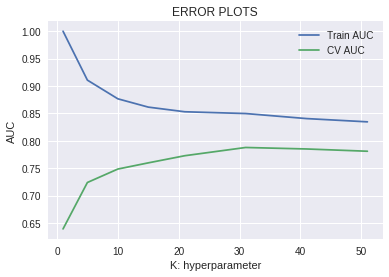

In [16]:
from sklearn.metrics import roc_auc_score


train_auc = []
cv_auc = []
k_values = [1, 5, 10, 15, 21, 31, 41, 51]
for i in k_values:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
    neigh.fit(x_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(k_values, train_auc, label='Train AUC')
plt.plot(k_values, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

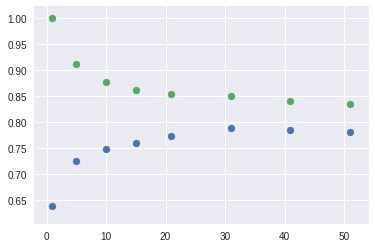

In [17]:
# Distribution of K values

plt.scatter(k_values,cv_auc)
plt.scatter(k_values,train_auc)

In [0]:
 # we can select the values in the range from 10 to 31, but to avoid overfitting, i.e. high variance smaller value of K should be choosen

In [0]:
optimal_k_bow = 13 # selecting this value ok K

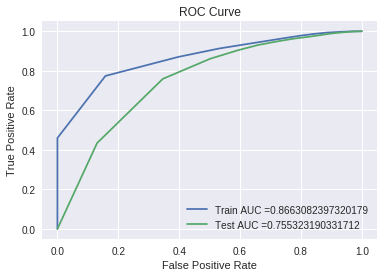

In [32]:
from sklearn.metrics import roc_curve, auc


neigh_bow = KNeighborsClassifier(n_neighbors=optimal_k_bow,algorithm="brute")
neigh_bow.fit(x_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_bow.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_bow.predict_proba(x_test_bow)[:,1])

train_bow_acc = auc(train_fpr, train_tpr)
test_bow_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


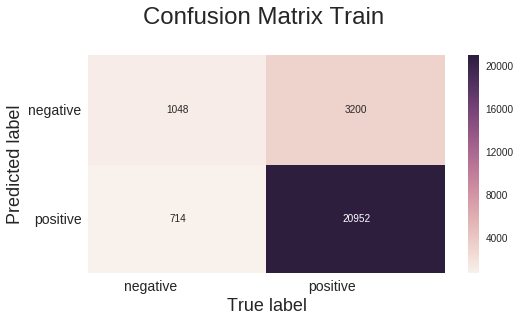

In [33]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_bow = pd.DataFrame(confusion_matrix(y_train, neigh_bow.predict(x_train_bow)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_bow = sns.heatmap(df_heatmap_bow, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_bow.yaxis.set_ticklabels(heatmap_bow.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_bow.xaxis.set_ticklabels(heatmap_bow.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train \n",size=24)
plt.show()

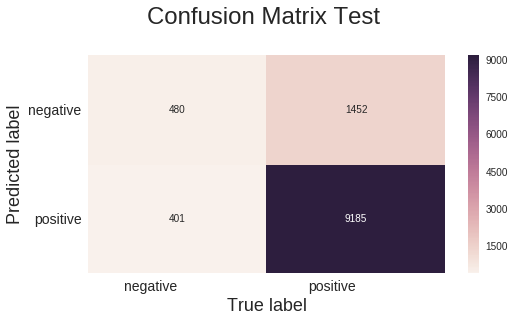

In [0]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_bow = pd.DataFrame(confusion_matrix(y_test, neigh_bow.predict(x_test_bow)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_bow = sns.heatmap(df_heatmap_bow, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_bow.yaxis.set_ticklabels(heatmap_bow.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_bow.xaxis.set_ticklabels(heatmap_bow.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test \n",size=24)
plt.show()


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
tfidf_vect = TfidfVectorizer()

x_train_tfidf = tfidf_vect.fit_transform(X_train)
x_test_tfidf = tfidf_vect.transform(X_test)
x_cv_tfidf = tfidf_vect.transform(X_cv)



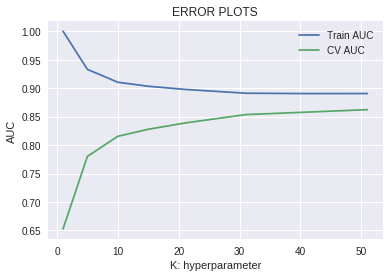

In [36]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
    neigh.fit(x_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

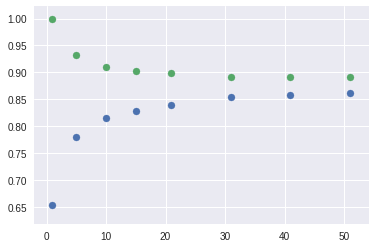

In [37]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
optimal_k_tfidf = 15

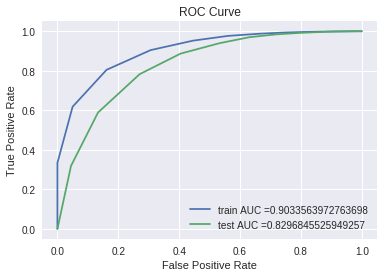

In [46]:
neigh_tfidf = KNeighborsClassifier(n_neighbors=optimal_k_tfidf,algorithm="brute")
neigh_tfidf.fit(x_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_tfidf.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_tfidf.predict_proba(x_test_tfidf)[:,1])

train_tfidf_acc = auc(train_fpr, train_tpr)
test_tfidf_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


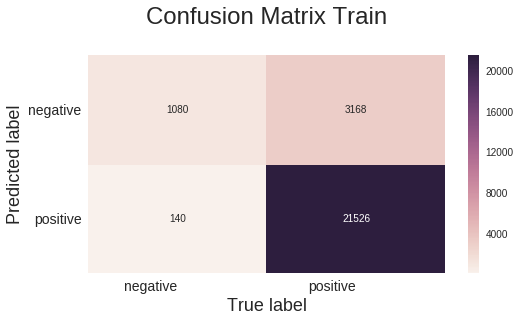

In [45]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_tfidf = pd.DataFrame(confusion_matrix(y_train, neigh_tfidf.predict(x_train_tfidf)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_tfidf = sns.heatmap(df_heatmap_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidf.yaxis.set_ticklabels(heatmap_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidf.xaxis.set_ticklabels(heatmap_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

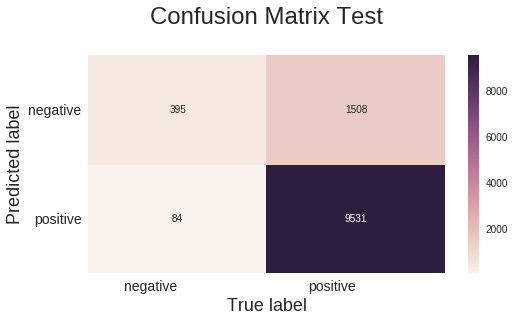

In [47]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_tfidf = pd.DataFrame(confusion_matrix(y_test, neigh_tfidf.predict(x_test_tfidf)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_tfidf = sns.heatmap(df_heatmap_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidf.yaxis.set_ticklabels(heatmap_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidf.xaxis.set_ticklabels(heatmap_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [48]:
# # Please write all the code with proper documentation

# # List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   

# List of sentence in X_cv
sent_of_cv=[]
for sent in X_cv:
    sent_of_cv.append(sent.split())   

# # Train your own Word2Vec model using your own train text corpus 
# # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=100, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


train_vectors = []
for sent in sent_of_train:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []
for sent in sent_of_test:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_cv    
cv_vectors = []
for sent in sent_of_cv:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec)

number of words that occured minimum 5 times  10055


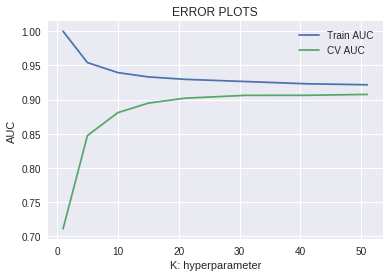

In [49]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
    neigh.fit(train_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_vectors)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

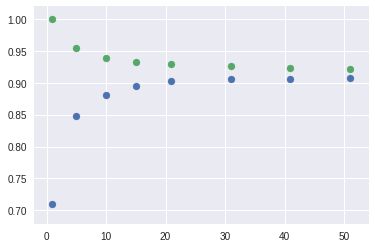

In [50]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
optimal_value_avgw2vec_k = 21

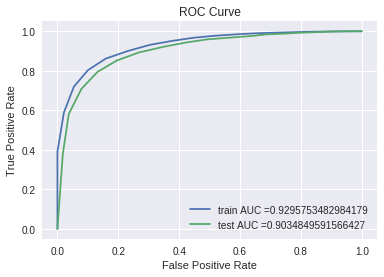

In [54]:
neigh_avgw2vec = KNeighborsClassifier(n_neighbors=optimal_value_avgw2vec_k,algorithm="brute")
neigh_avgw2vec.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_avgw2vec.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_avgw2vec.predict_proba(test_vectors)[:,1])

train_avgw2vec_acc = auc(train_fpr, train_tpr)
test_avgw2vec_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


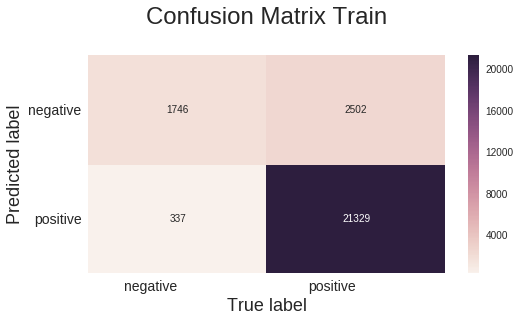

In [55]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec = pd.DataFrame(confusion_matrix(y_train, neigh_avgw2vec.predict(train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec = sns.heatmap(df_heatmap_avgw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec.yaxis.set_ticklabels(heatmap_avgw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec.xaxis.set_ticklabels(heatmap_avgw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

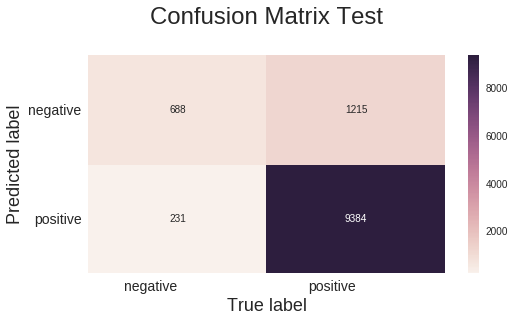

In [56]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec = pd.DataFrame(confusion_matrix(y_test, neigh_avgw2vec.predict(test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec = sns.heatmap(df_heatmap_avgw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec.yaxis.set_ticklabels(heatmap_avgw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec.xaxis.set_ticklabels(heatmap_avgw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [57]:
# Please write all the code with proper documentation

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_train): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1
    
    
tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_test): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1
    
    
    
tfidf_w2v_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_cv): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_cv.append(sent_vec)
    row += 1

100%|██████████| 8639/8639 [02:25<00:00, 59.23it/s]


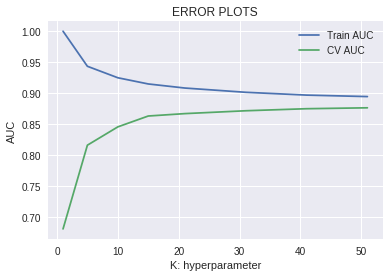

In [58]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
    neigh.fit(tfidf_w2v_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_w2v_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_w2v_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

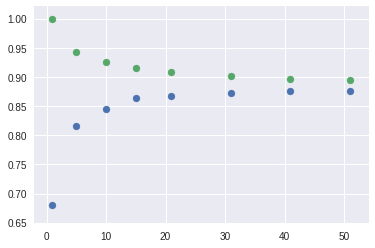

In [59]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
optimal_value_tfidfw2vec_k = 19

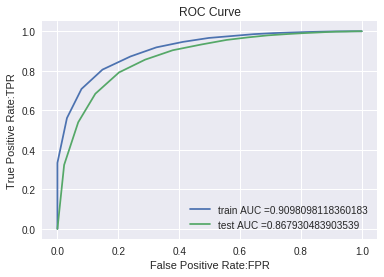

In [65]:
avgw2vec_tfidf_knn_model_optimal = KNeighborsClassifier(algorithm='brute',n_neighbors=optimal_value_tfidfw2vec_k)
avgw2vec_tfidf_knn_model_optimal.fit(tfidf_w2v_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, avgw2vec_tfidf_knn_model_optimal.predict_proba(tfidf_w2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, avgw2vec_tfidf_knn_model_optimal.predict_proba(tfidf_w2v_test)[:,1])

train_tfidfw2v_acc = auc(train_fpr, train_tpr)
test_tfidfw2v_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_tfidfw2v_acc))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_tfidfw2v_acc))
plt.legend()
plt.xlabel("False Positive Rate:FPR")
plt.ylabel("True Positive Rate:TPR")
plt.title("ROC Curve")
plt.show()

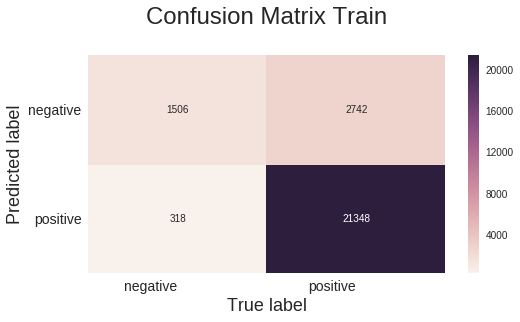

In [66]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec_tfidf = pd.DataFrame(confusion_matrix(y_train, avgw2vec_tfidf_knn_model_optimal.predict(tfidf_w2v_train)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec_tfidf = sns.heatmap(df_heatmap_avgw2vec_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec_tfidf.yaxis.set_ticklabels(heatmap_avgw2vec_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec_tfidf.xaxis.set_ticklabels(heatmap_avgw2vec_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

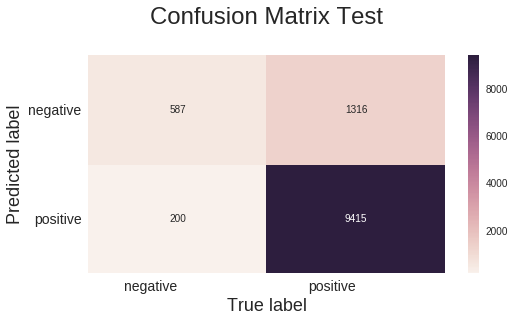

In [67]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec_tfidf = pd.DataFrame(confusion_matrix(y_test, avgw2vec_tfidf_knn_model_optimal.predict(tfidf_w2v_test)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec_tfidf = sns.heatmap(df_heatmap_avgw2vec_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec_tfidf.yaxis.set_ticklabels(heatmap_avgw2vec_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec_tfidf.xaxis.set_ticklabels(heatmap_avgw2vec_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD
count_vect = CountVectorizer(min_df=10, max_features=500)

x_train = count_vect.fit_transform(X_train)
x_test = count_vect.transform(X_test)
x_cv = count_vect.transform(X_cv)
svd = TruncatedSVD(n_components=100)

x_train_dense_bow = svd.fit_transform(x_train)
x_test_dense_bow = svd.transform(x_test)
x_cv_dense_bow = svd.transform(x_cv)

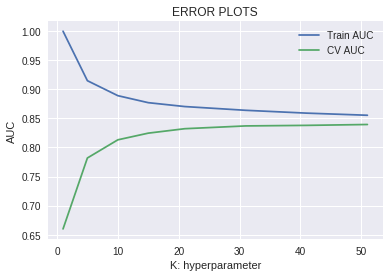

In [72]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(x_train_dense_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train_dense_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv_dense_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

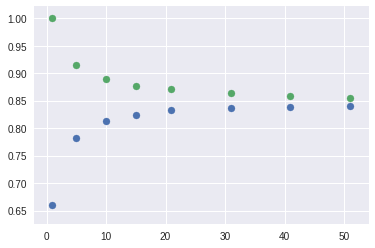

In [73]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
values_bow_kd = 11

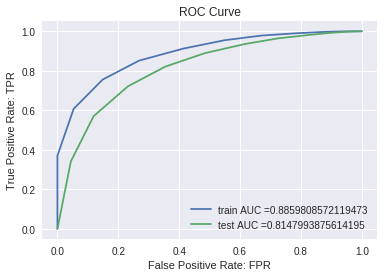

In [76]:
# Testing Our Model 

bow_model_optimal_kd = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=values_bow_kd)

bow_model_optimal_kd.fit(x_train_dense_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, bow_model_optimal_kd.predict_proba(x_train_dense_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, bow_model_optimal_kd.predict_proba(x_test_dense_bow)[:,1])

train_bow_kd_acc = auc(train_fpr, train_tpr)
test_bow_kd_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_bow_kd_acc))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_bow_kd_acc))
plt.legend()
plt.xlabel("False Positive Rate: FPR")
plt.ylabel("True Positive Rate: TPR")
plt.title("ROC Curve")
plt.show()

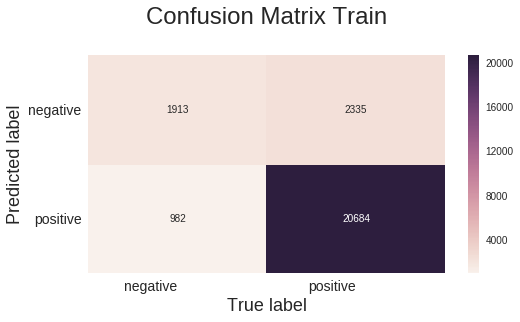

In [77]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_bow_kd = pd.DataFrame(confusion_matrix(y_train, bow_model_optimal_kd.predict(x_train_dense_bow)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_bow_kd = sns.heatmap(df_heatmap_bow_kd, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_bow_kd.yaxis.set_ticklabels(heatmap_bow_kd.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_bow_kd.xaxis.set_ticklabels(heatmap_bow_kd.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

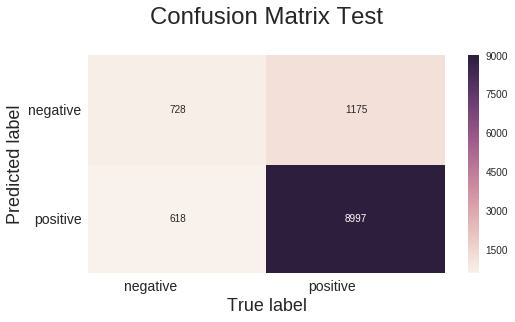

In [78]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_bow_kd = pd.DataFrame(confusion_matrix(y_test, bow_model_optimal_kd.predict(x_test_dense_bow)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_bow_kd = sns.heatmap(df_heatmap_bow_kd, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_bow_kd.yaxis.set_ticklabels(heatmap_bow_kd.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_bow_kd.xaxis.set_ticklabels(heatmap_bow_kd.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
# Please write all the code with proper documentation
tfidf_vect = TfidfVectorizer(min_df=10, max_features=500)

x_train = tfidf_vect.fit_transform(X_train)
x_test = tfidf_vect.transform(X_test)
x_cv = tfidf_vect.transform(X_cv)
svd_2 = TruncatedSVD(n_components=100)

x_train_dense_tfidf = svd_2.fit_transform(x_train)
x_test_dense_tfidf = svd_2.transform(x_test)
x_cv_dense_tfidf = svd_2.transform(x_cv)

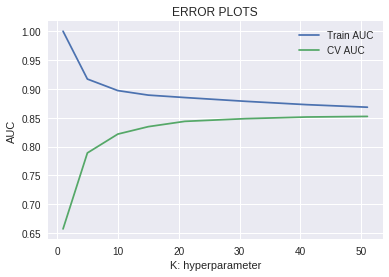

In [85]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(x_train_dense_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train_dense_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv_dense_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

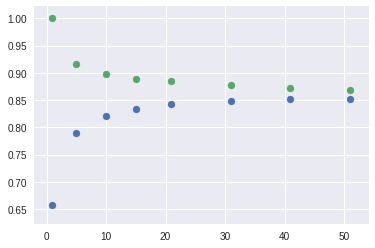

In [86]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
values_tfidf_kd = 17

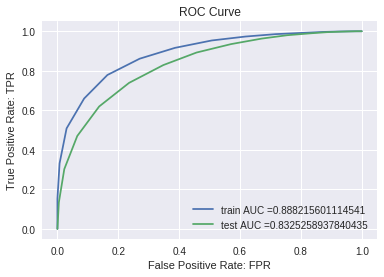

In [90]:
# Testing Our Model 

tfidf_model_optimal_kd = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=values_tfidf_kd)
tfidf_model_optimal_kd.fit(x_train_dense_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, tfidf_model_optimal_kd.predict_proba(x_train_dense_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, tfidf_model_optimal_kd.predict_proba(x_test_dense_tfidf)[:,1])

train_tfidf_kd_acc = auc(train_fpr, train_tpr)
test_tfidf_kd_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_tfidf_kd_acc))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_tfidf_kd_acc))
plt.legend()
plt.xlabel("False Positive Rate: FPR")
plt.ylabel("True Positive Rate: TPR")
plt.title("ROC Curve")
plt.show()

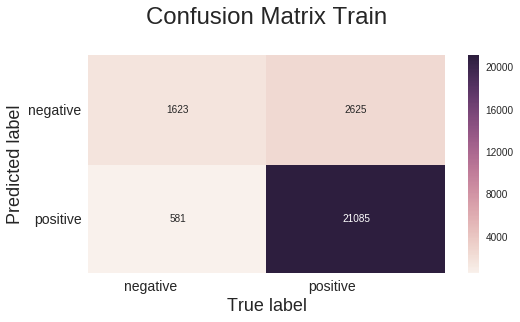

In [91]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_tfidf_kd = pd.DataFrame(confusion_matrix(y_train, tfidf_model_optimal_kd.predict(x_train_dense_tfidf)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_tfidf_kd = sns.heatmap(df_heatmap_tfidf_kd, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidf_kd.yaxis.set_ticklabels(heatmap_tfidf_kd.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidf_kd.xaxis.set_ticklabels(heatmap_tfidf_kd.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

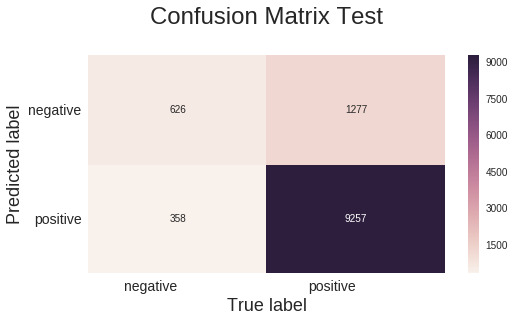

In [92]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_tfidf_kd = pd.DataFrame(confusion_matrix(y_test, tfidf_model_optimal_kd.predict(x_test_dense_tfidf)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_tfidf_kd = sns.heatmap(df_heatmap_tfidf_kd, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidf_kd.yaxis.set_ticklabels(heatmap_tfidf_kd.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidf_kd.xaxis.set_ticklabels(heatmap_tfidf_kd.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

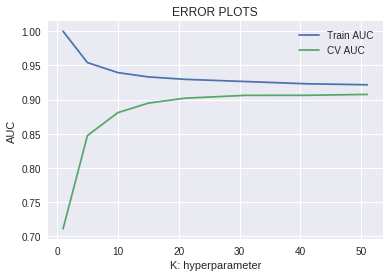

In [93]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(train_vectors, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(train_vectors)[:,1]
    y_cv_pred =  neigh.predict_proba(cv_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

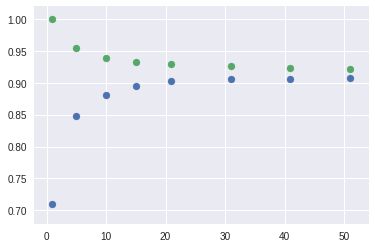

In [94]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
values_avg2wv_kd = 13

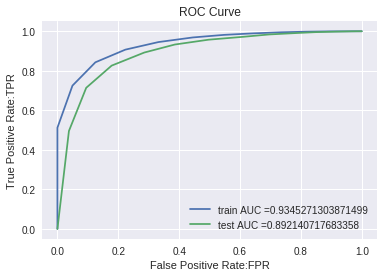

In [96]:
avgw2vec_optimal = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=values_avg2wv_kd)
avgw2vec_optimal.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, avgw2vec_optimal.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, avgw2vec_optimal.predict_proba(test_vectors)[:,1])

train_avgw2v_kd_acc = auc(train_fpr, train_tpr)
test_avgw2v_kd_acc =  auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_avgw2v_kd_acc))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_avgw2v_kd_acc))
plt.legend()
plt.xlabel("False Positive Rate:FPR")
plt.ylabel("True Positive Rate:TPR")
plt.title("ROC Curve")
plt.show()

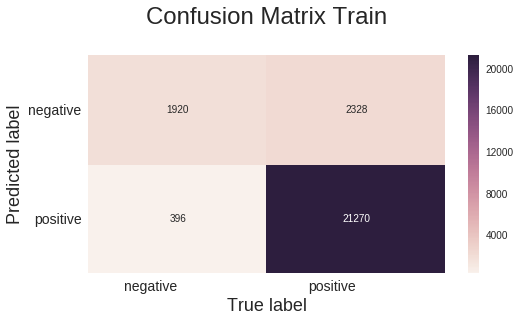

In [97]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec = pd.DataFrame(confusion_matrix(y_train, avgw2vec_optimal.predict(train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec = sns.heatmap(df_heatmap_avgw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec.yaxis.set_ticklabels(heatmap_avgw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec.xaxis.set_ticklabels(heatmap_avgw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

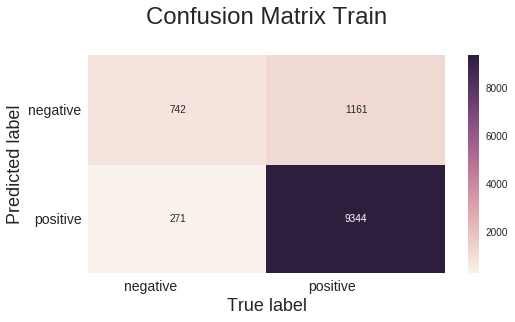

In [98]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec = pd.DataFrame(confusion_matrix(y_test, avgw2vec_optimal.predict(test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec = sns.heatmap(df_heatmap_avgw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec.yaxis.set_ticklabels(heatmap_avgw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec.xaxis.set_ticklabels(heatmap_avgw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

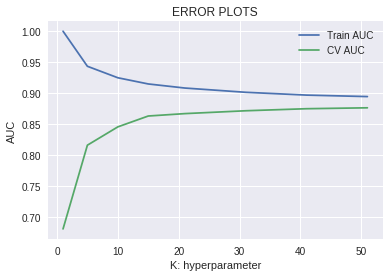

In [99]:
# Please write all the code with proper documentation
# values_tfidf_avgw2v_kd = optimal_values_kd(tfidf_w2v_train,y_train)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(tfidf_w2v_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_w2v_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_w2v_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

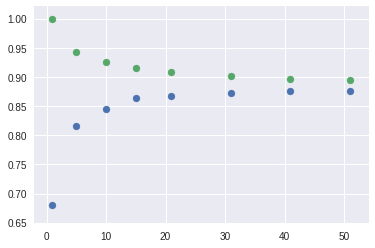

In [100]:
# Distribution of K values

plt.scatter(K,cv_auc)
plt.scatter(K,train_auc)

In [0]:
values_tfidf_avgw2v_kd = 15

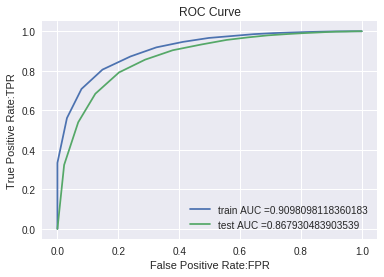

In [112]:
avgw2vec_tfidf_kd_optimal = KNeighborsClassifier(algorithm='kd_tree',n_neighbors=values_tfidf_avgw2v_kd)
avgw2vec_tfidf_kd_optimal.fit(tfidf_w2v_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, avgw2vec_tfidf_knn_model_optimal.predict_proba(tfidf_w2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, avgw2vec_tfidf_knn_model_optimal.predict_proba(tfidf_w2v_test)[:,1])

train_tfidfw2v_kd_acc = auc(train_fpr, train_tpr)
test_tfidfw2v_kd_acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_tfidfw2v_kd_acc))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_tfidfw2v_kd_acc))
plt.legend()
plt.xlabel("False Positive Rate:FPR")
plt.ylabel("True Positive Rate:TPR")
plt.title("ROC Curve")
plt.show()

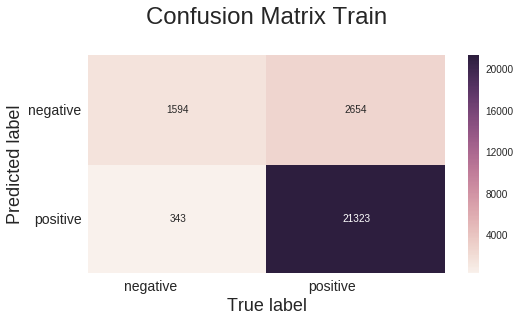

In [113]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec_tfidf = pd.DataFrame(confusion_matrix(y_train, avgw2vec_tfidf_kd_optimal.predict(tfidf_w2v_train)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec_tfidf = sns.heatmap(df_heatmap_avgw2vec_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec_tfidf.yaxis.set_ticklabels(heatmap_avgw2vec_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec_tfidf.xaxis.set_ticklabels(heatmap_avgw2vec_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

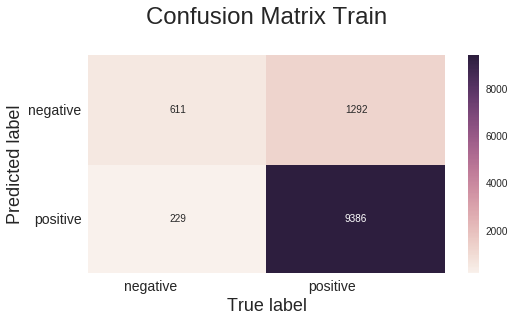

In [114]:
# Plotting Heat Map of confusion matrix using seaborn

class_names = ['negative','positive']
df_heatmap_avgw2vec_tfidf = pd.DataFrame(confusion_matrix(y_test, avgw2vec_tfidf_kd_optimal.predict(tfidf_w2v_test)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(8,4))
heatmap_avgw2vec_tfidf = sns.heatmap(df_heatmap_avgw2vec_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec_tfidf.yaxis.set_ticklabels(heatmap_avgw2vec_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec_tfidf.xaxis.set_ticklabels(heatmap_avgw2vec_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

# [6] Conclusions

In [117]:
# Please compare all your models using Prettytable library
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["KNN using 'brute' for BoW","KNN using 'brute' for TFIDF","KNN using 'brute' for Avg-Word2Vec",
         "KNN using 'brute' for TFIDF-Word2Vec","KNN using 'kdTree' for BoW",
        "KNN using 'kdTree' for TFIDF",  "KNN using 'kdTree' for Avg-Word2Vec",
         "KNN using 'kdTree' for TFIDF-Word2Vec"]

optimal_K = [optimal_k_bow, optimal_k_tfidf, optimal_value_avgw2vec_k,optimal_value_tfidfw2vec_k,             
            values_bow_kd, values_tfidf_kd,
            values_avg2wv_kd,values_tfidf_avgw2v_kd]

train_acc = [train_bow_acc, train_tfidf_acc,train_avgw2vec_acc, train_tfidfw2v_acc,
             train_bow_kd_acc, train_tfidf_kd_acc, train_avgw2v_kd_acc, train_tfidfw2v_kd_acc]

test_acc = [test_bow_acc, test_tfidf_acc, test_avgw2vec_acc,test_tfidfw2v_acc,
            test_bow_kd_acc, test_tfidf_kd_acc, test_avgw2v_kd_acc, test_tfidfw2v_kd_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",optimal_K)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+---------------------------------------+--------+--------------------+--------------------+
| S.NO. |                 MODEL                 | Best K | Training Accuracy  |   Test Accuracy    |
+-------+---------------------------------------+--------+--------------------+--------------------+
|   1   |       KNN using 'brute' for BoW       |   13   | 0.8663082397320179 | 0.755323190331712  |
|   2   |      KNN using 'brute' for TFIDF      |   15   | 0.9033563972763698 | 0.8296845525949257 |
|   3   |   KNN using 'brute' for Avg-Word2Vec  |   21   | 0.9295753482984179 | 0.9034849591566427 |
|   4   |  KNN using 'brute' for TFIDF-Word2Vec |   19   | 0.9098098118360183 | 0.867930483903539  |
|   5   |       KNN using 'kdTree' for BoW      |   11   | 0.8859808572119473 | 0.8147993875614195 |
|   6   |      KNN using 'kdTree' for TFIDF     |   17   | 0.888215601114541  | 0.8325258937840435 |
|   7   |  KNN using 'kdTree' for Avg-Word2Vec  |   13   | 0.9345271303871499 | 0.892140717